# Multiple Runs Analysis

Notebook to test functions for mutiple runs simultaneously.

In [1]:
import nbimporter
import prepData as prep
import fitFunc as fits
import Statistics as stat

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math

import multiprocessing
import time

from scipy.stats import norm

## Table of Contents

1. [Load Dataset](#load) <br>
2. [Preliminary Fits](#fits) <br>
    2.1. [Backgroun Fit](#fits_bkg) <br>
    2.2. [Signal Fit](#fits_sig) <br>
3. [Statistical Analysis](#stats) <br>
    3.1. [Significance](#stats_sign) <br>
    3.2. [Confidence Interval](#stats_ci) <br> 
    3.3  [Parallelization of Confidence interval test](#parallel) <br>

## 1. Load dataset <a name="load"></a>

In [2]:
runsData = prep.Load()

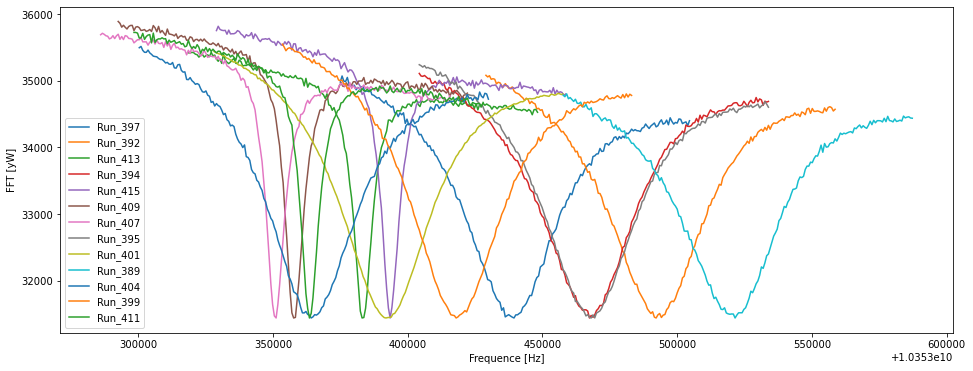

In [3]:
mins=np.empty(len(runsData))
maxs=np.empty(len(runsData))

fig = plt.figure(figsize=(16, 6))

for i_run,run in enumerate(runsData):
    
    runName=run["name"][28:35]
    plt.plot(run["freq"],run["fft"],label=runName)
    plt.xlabel('Frequence [Hz]')
    plt.ylabel('FFT [yW]')
    
plt.legend()
plt.show()

## 2. Preliminary Fits <a name="fits"></a>

### 2.1. Background Fit <a name="fits_bkg"></a>

As a preliminary check, we will fit the background function

$$exp \left( 2 \cdot \frac{|x - a+ib|^2}{|x - c+id|^2} + f \cdot (x - c) \right)$$

and study the distribution of residuals.

In [4]:
fitBkg = fits.multipleFitBKG(runsData)

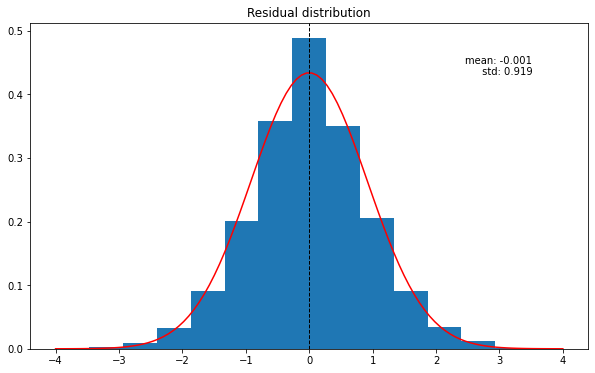

In [5]:
residuals=[]

for i_run,run in enumerate(fitBkg):
    residuals.append(run["bkg_residuals"])

residuals=np.array(residuals).flatten()
rangeMax = int(np.max(residuals))+1

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.hist(residuals,bins=15, density=True, range=(-rangeMax,rangeMax))

fit_res = norm.fit(residuals, loc=0, scale=1)
ax.plot(np.linspace(-rangeMax, rangeMax, 100),
             norm.pdf(np.linspace(-rangeMax, rangeMax, 100), fit_res[0], fit_res[1]), color="red")
ax.axvline(fit_res[0], color='black', linestyle='dashed', linewidth=1)
    
summary_text = "mean: {}\n std: {}".format(np.round(fit_res[0],3), np.round(fit_res[1], 3))
ax.text(0.9, 0.9, summary_text, transform=fig.gca().transAxes, ha='right', va='top')
ax.set_title("Residual distribution")
plt.show()

### 2.1. Signal Fit <a name="fits_sig"></a>

We will now fit the data with a gaussian signal over the background

$$\mu \cdot exp \left( -\frac{1}{2} \frac{(x - x_0)^2}{\sigma^2} \right)$$

using every possible frequency as the centre of the signal $x_0$.

In [6]:
x0=1.035e10+400000
fitSig = fits.multipleFitSIG(runsData, fitBkg, x_0=x0)

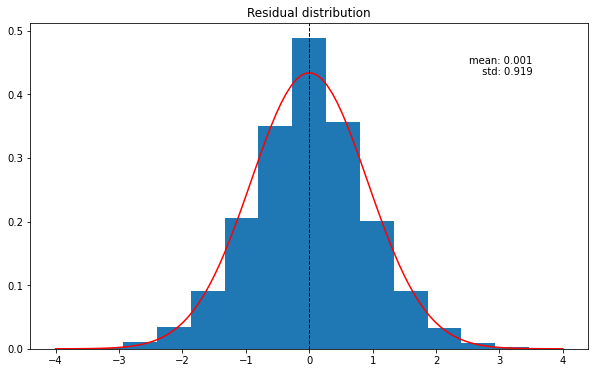

In [7]:
residuals=[]

for i_run,run in enumerate(fitSig):
    residuals.append(run["sig_residuals"]/run["weights"])

residuals=np.array(residuals).flatten()
rangeMax = int(np.max(residuals))+1

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.hist(residuals,bins=15, density=True, range=(-rangeMax,rangeMax))

fit_res = norm.fit(residuals, loc=0, scale=1)
ax.plot(np.linspace(-rangeMax, rangeMax, 100),
             norm.pdf(np.linspace(-rangeMax, rangeMax, 100), fit_res[0], fit_res[1]), color="red")
ax.axvline(fit_res[0], color='black', linestyle='dashed', linewidth=1)
    
summary_text = "mean: {}\n std: {}".format(np.round(fit_res[0],3), np.round(fit_res[1], 3))
ax.text(0.9, 0.9, summary_text, transform=fig.gca().transAxes, ha='right', va='top')
ax.set_title("Residual distribution")
plt.show()

## 3. Statistical Analysis <a name="stats"></a>

### 3.1. Significance <a name="stats_sign"></a>

Assuming the presence of a signal, we will now compute its significance. As more thoroughly explained in the "Statistics" notebook, this quantity is computed from the p-value of the observed likelihood ratio

$$q_0^{obs} = -2 \cdot \log \left( \cfrac{\mathcal{L} \left(Data | 0, \hat{\theta}_0 \right)}{\mathcal{L} \left(Data | \hat{\mu}, \hat{\theta}_\hat{\mu} \right)}\right)$$

with respect to a distribution ob of $q_0$ obtained from toy datasets.  
Every recorded frequency is investigated as a possible center of the signal, $x_0$. 

In [9]:
all_freq=np.linspace(10353286068+16*651, 10353286068+31*16*651,30)

signif_x0=all_freq[range(0,28,5)]

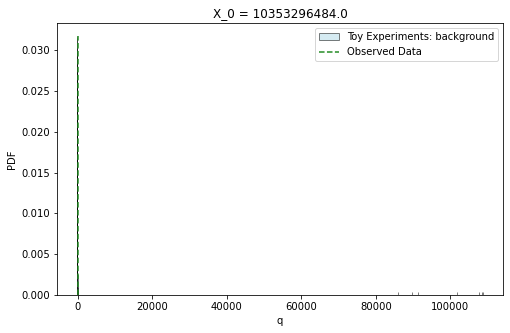

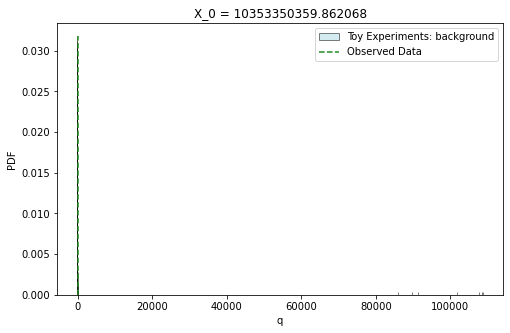

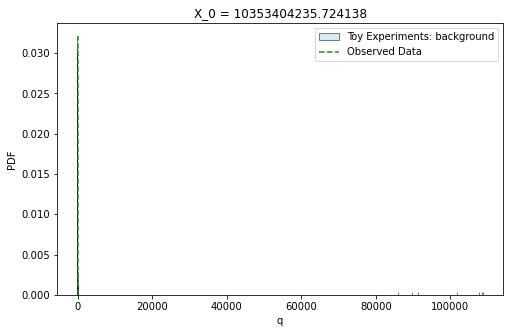

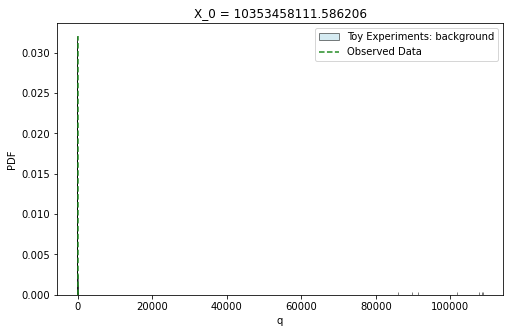

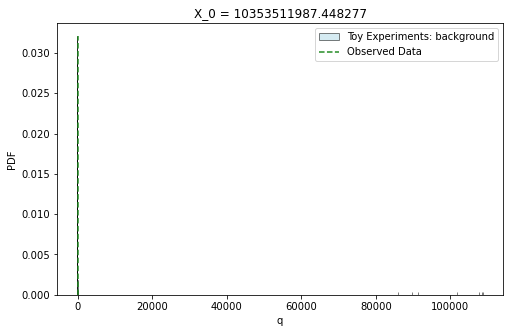

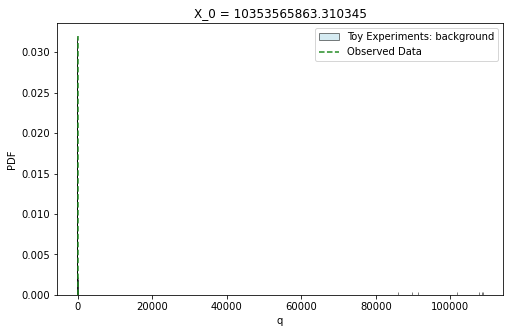

In [10]:
z,_=stat.stat_test(runsData,signif_x0,nToy=1000,calc_CI=False,calc_z=True,verbose=True,draw=True)

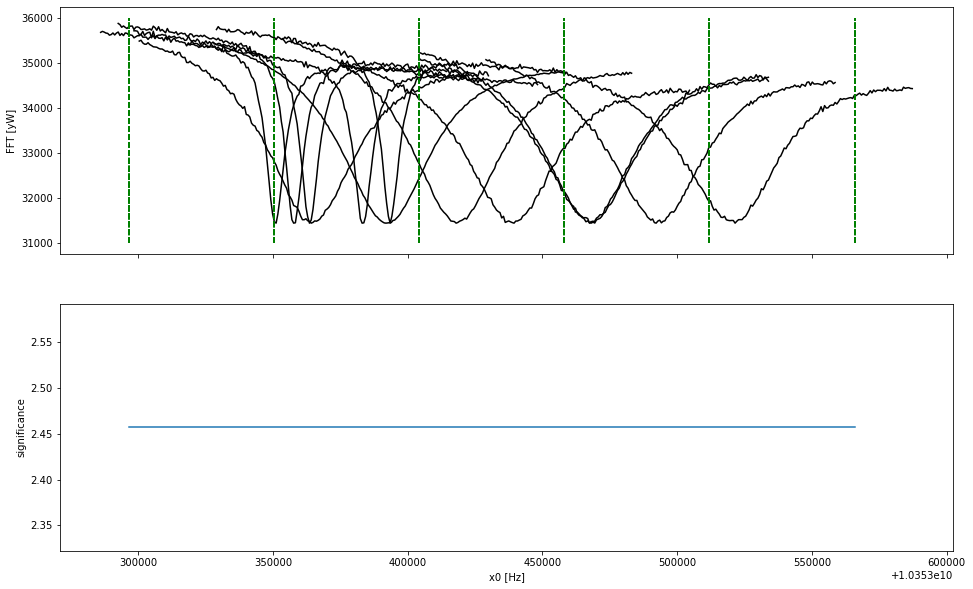

In [17]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")
    ax[0].vlines(signif_x0,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(signif_x0,z)

ax[0].set_ylabel("FFT [yW]")
ax[1].set_xlabel("x0 [Hz]")
ax[1].set_ylabel("significance")
plt.show()

### 3.2. Confidence Interval <a name="stats_ci"></a>

We are now interested in setting a limit on the strength of the signal, thus computing $\mu^{95\% CL}$. It would not be correct *a priori* to do both this and the previous staistical test, as they start from different assumptions on the presence of the signal or lack thereof; we will still be showing both for a more complete discussion.  

#### Range(0,5)

Testing x0: 10353296484.0
Mu:  10    q(mu)_obs = 12.560410596284783
p_mu = 0.001   p_b = 0.036   ratio = 0.02777777777777778 

Mu:  8.0    q(mu)_obs = 8.893684146594751
p_mu = 0.003   p_b = 0.036   ratio = 0.08333333333333334 



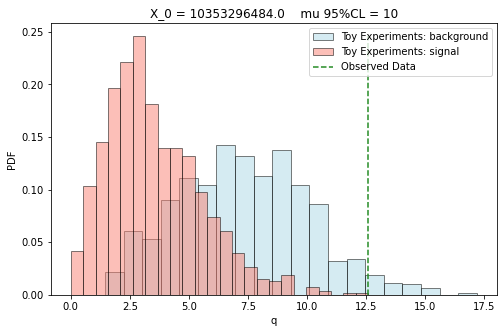

mu_CI: 10.0
---------------------
Testing x0: 10353307259.172413
Mu:  10.0    q(mu)_obs = 5.96060477694482
p_mu = 0.628   p_b = 0.969   ratio = 0.6480908152734778 

Mu:  20.0    q(mu)_obs = 34.12053330912022
p_mu = 0.099   p_b = 0.969   ratio = 0.10216718266253871 

Mu:  22.0    q(mu)_obs = 42.52415587215364
p_mu = 0.056   p_b = 0.969   ratio = 0.057791537667698664 



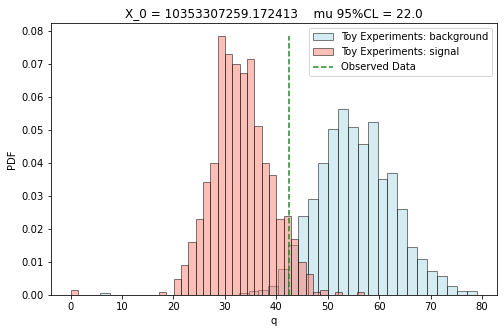

mu_CI: 22.0
---------------------
Testing x0: 10353318034.344828
Mu:  22.0    q(mu)_obs = 38.68983464118355
p_mu = 0.164   p_b = 0.999   ratio = 0.16416416416416418 

Mu:  27.0    q(mu)_obs = 65.7879467789353
p_mu = 0.02   p_b = 0.998   ratio = 0.02004008016032064 

Mu:  25.0    q(mu)_obs = 54.0913768432365
p_mu = 0.067   p_b = 0.999   ratio = 0.06706706706706707 



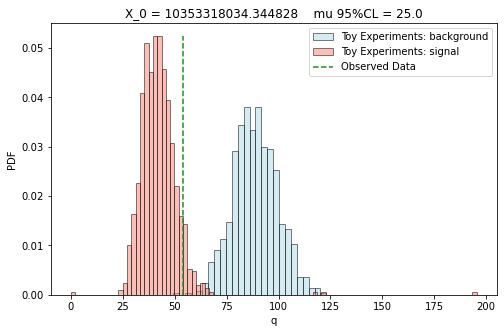

mu_CI: 25.0
---------------------
Testing x0: 10353328809.51724
Mu:  25.0    q(mu)_obs = 77.73871927184518
p_mu = 0.011   p_b = 1.0   ratio = 0.011 

Mu:  23.0    q(mu)_obs = 63.27341765995516
p_mu = 0.031   p_b = 1.0   ratio = 0.031 

Mu:  21.0    q(mu)_obs = 50.294740587021806
p_mu = 0.063   p_b = 1.0   ratio = 0.063 



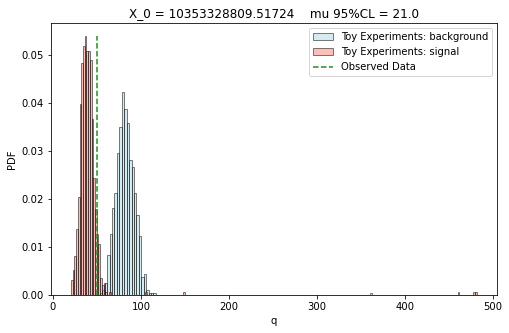

mu_CI: 21.0
---------------------
Testing x0: 10353339584.689655
Mu:  21.0    q(mu)_obs = 86.3118500747114
p_mu = 0.003   p_b = 0.849   ratio = 0.0035335689045936395 

Mu:  19.0    q(mu)_obs = 69.81251225701635
p_mu = 0.007   p_b = 0.849   ratio = 0.008244994110718492 

Mu:  17.0    q(mu)_obs = 55.06040599604603
p_mu = 0.006   p_b = 0.849   ratio = 0.007067137809187279 

Mu:  15.0    q(mu)_obs = 42.05602294242999
p_mu = 0.021   p_b = 0.849   ratio = 0.02473498233215548 

Mu:  13.0    q(mu)_obs = 30.79985489290266
p_mu = 0.054   p_b = 0.849   ratio = 0.06360424028268552 



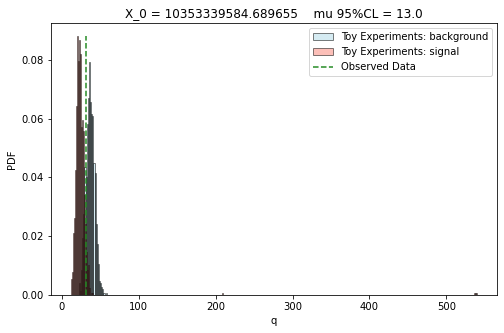

mu_CI: 13.0
---------------------


In [6]:
x0_1=all_freq[range(0,5)]
muCL1=stat.stat_test(runsData,x0_1,mu_fix=10,verbose=True,draw=True)

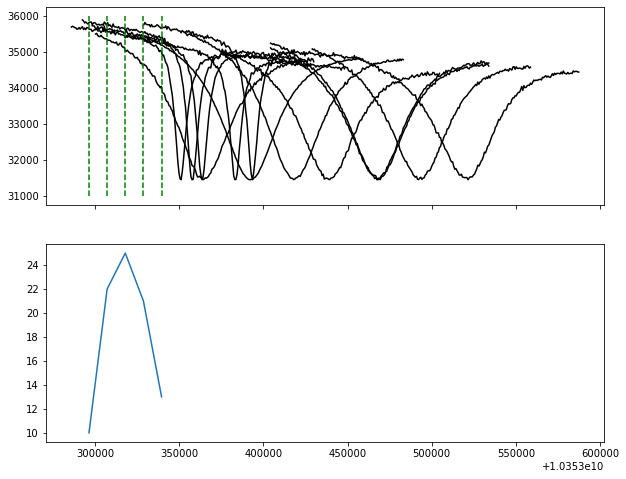

In [18]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0:
    ax[0].vlines(x0_1,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_1,muCL1)

#### Range(5,10)

Testing x0: 10353350359.862068
Mu:  13    q(mu)_obs = 52.84211933710321
p_mu = 0.005   p_b = 0.011   ratio = 0.4545454545454546 

Mu:  20.0    q(mu)_obs = 115.00716139907308
p_mu = 0.013   p_b = 0.011   ratio = 1.1818181818181819 

Mu:  30.0    q(mu)_obs = 244.69152682006825
p_mu = 0.003   p_b = 0.009   ratio = 0.33333333333333337 

Mu:  37.0    q(mu)_obs = 364.05196974497085
p_mu = 0.0   p_b = 0.009   ratio = 0.0 

Mu:  35.0    q(mu)_obs = 327.5489009685152
p_mu = 0.001   p_b = 0.009   ratio = 0.11111111111111112 



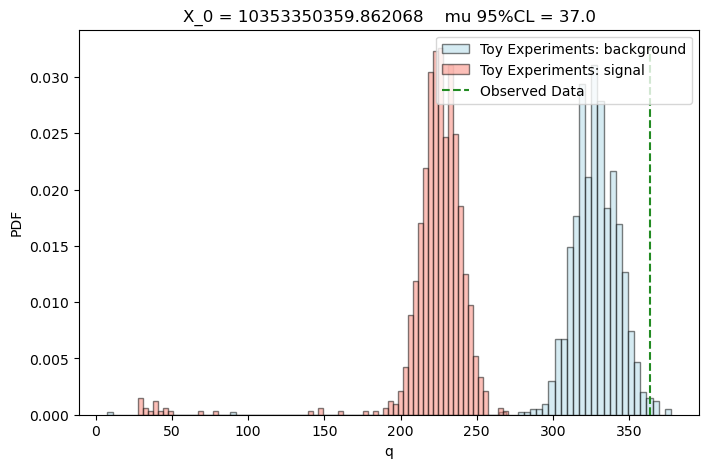

mu_CI: 37.0
---------------------
Testing x0: 10353361135.034483
Mu:  37.0    q(mu)_obs = 407.4770484905348
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  35.0    q(mu)_obs = 367.0508660769847
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  33.0    q(mu)_obs = 328.7242257843682
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  31.0    q(mu)_obs = 292.49773784178615
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  29.0    q(mu)_obs = 258.3720126669905
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  27.0    q(mu)_obs = 226.34766086595482
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  25.0    q(mu)_obs = 196.4252932333111
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  23.0    q(mu)_obs = 168.6055207523168
p_mu = 0.0   p_b = 0.001   ratio = 0.0 

Mu:  21.0    q(mu)_obs = 142.88895459482956
p_mu = 0.002   p_b = 0.001   ratio = 2.0 



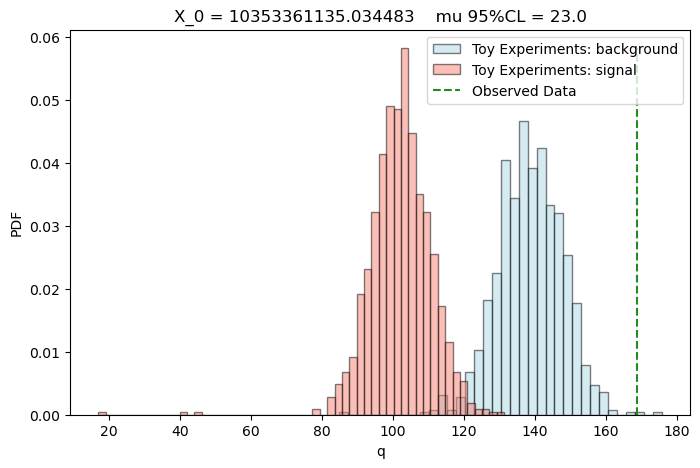

mu_CI: 23.0
---------------------
Testing x0: 10353371910.206896
Mu:  23.0    q(mu)_obs = 154.0681471709613
p_mu = 0.0   p_b = 0.193   ratio = 0.0 

Mu:  21.0    q(mu)_obs = 129.03685402159317
p_mu = 0.001   p_b = 0.193   ratio = 0.0051813471502590676 

Mu:  19.0    q(mu)_obs = 106.219566174379
p_mu = 0.0   p_b = 0.193   ratio = 0.0 

Mu:  17.0    q(mu)_obs = 85.61691691231681
p_mu = 0.0   p_b = 0.193   ratio = 0.0 

Mu:  15.0    q(mu)_obs = 67.2295397106318
p_mu = 0.001   p_b = 0.193   ratio = 0.0051813471502590676 

Mu:  13.0    q(mu)_obs = 51.058068236998224
p_mu = 0.002   p_b = 0.193   ratio = 0.010362694300518135 

Mu:  11.0    q(mu)_obs = 37.103136351172
p_mu = 0.005   p_b = 0.193   ratio = 0.025906735751295335 

Mu:  9.0    q(mu)_obs = 25.365378105441778
p_mu = 0.005   p_b = 0.193   ratio = 0.025906735751295335 

Mu:  7.0    q(mu)_obs = 15.845427744508925
p_mu = 0.015   p_b = 0.193   ratio = 0.07772020725388601 



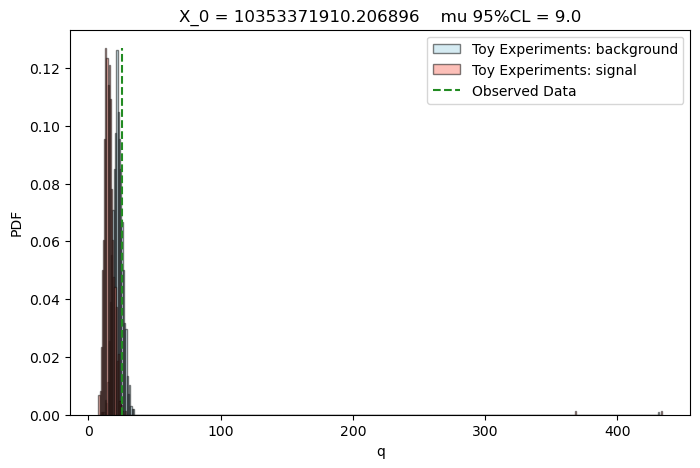

mu_CI: 9.0
---------------------
Testing x0: 10353382685.37931
Mu:  9.0    q(mu)_obs = 16.074144836013147
p_mu = 0.524   p_b = 0.982   ratio = 0.5336048879837068 

Mu:  16.0    q(mu)_obs = 61.08949742325058
p_mu = 0.077   p_b = 0.982   ratio = 0.07841140529531568 

Mu:  18.0    q(mu)_obs = 79.27004021775792
p_mu = 0.024   p_b = 0.982   ratio = 0.024439918533604887 



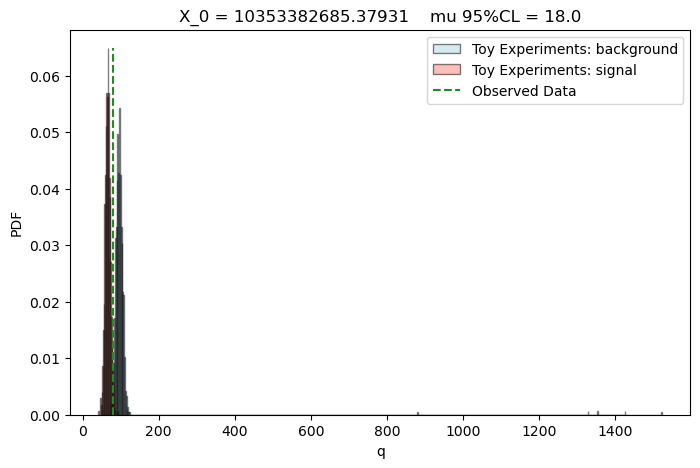

mu_CI: 18.0
---------------------
Testing x0: 10353393460.551723
Mu:  18.0    q(mu)_obs = 87.20220555692867
p_mu = 0.004   p_b = 0.926   ratio = 0.004319654427645789 

Mu:  16.0    q(mu)_obs = 67.76281961199857
p_mu = 0.007   p_b = 0.926   ratio = 0.007559395248380129 

Mu:  14.0    q(mu)_obs = 50.77009878141689
p_mu = 0.044   p_b = 0.926   ratio = 0.04751619870410367 



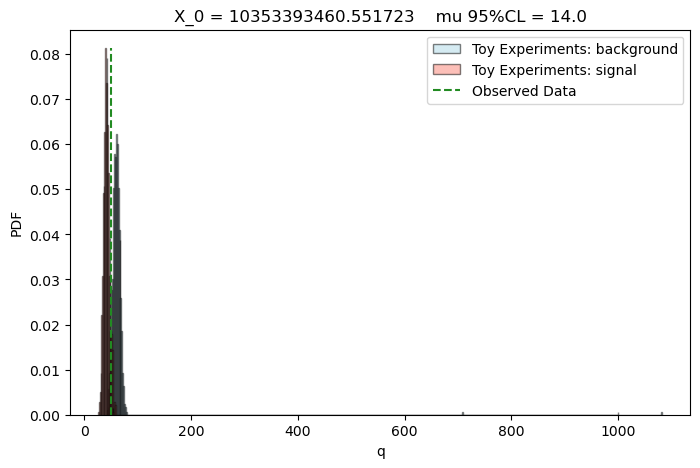

mu_CI: 14.0
---------------------


In [10]:
x0_2=all_freq[range(5,10)]
muCL2=stat.stat_test(runsData,x0_2,mu_fix=13,verbose=True,draw=True)

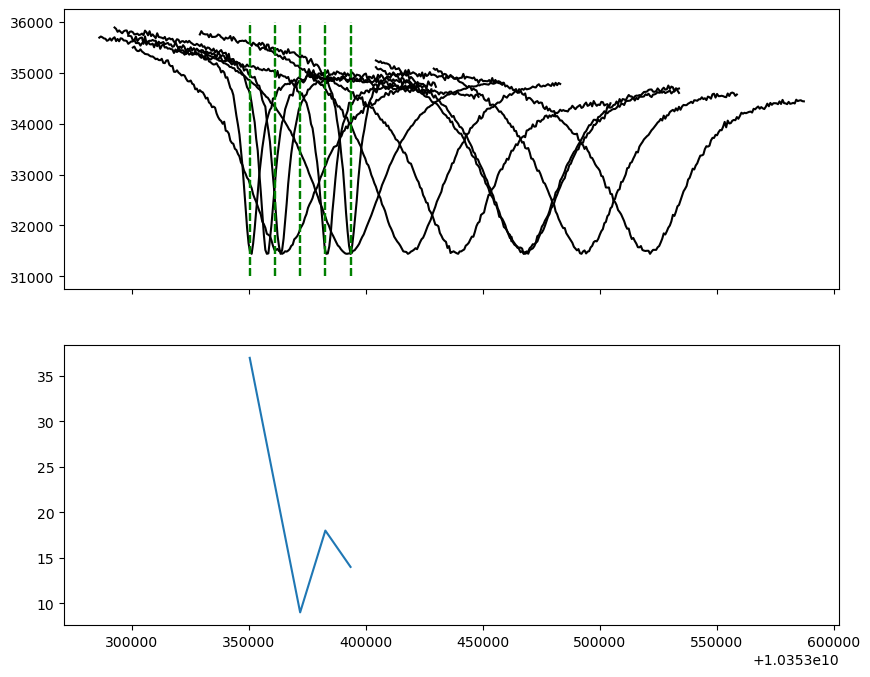

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0_2:
    ax[0].vlines(x0_2,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_2,muCL2)

#### Range(10,15)

Testing x0: 10353404235.724138
Mu:  14    q(mu)_obs = 74.17957447861045
p_mu = 0.007   p_b = 0.065   ratio = 0.10769230769230768 

Mu:  16.0    q(mu)_obs = 95.33132827281224
p_mu = 0.006   p_b = 0.065   ratio = 0.09230769230769231 

Mu:  18.0    q(mu)_obs = 119.1194727641523
p_mu = 0.006   p_b = 0.065   ratio = 0.09230769230769231 

Mu:  20.0    q(mu)_obs = 145.54324945258486
p_mu = 0.01   p_b = 0.065   ratio = 0.15384615384615385 

Mu:  25.0    q(mu)_obs = 223.12860646134504
p_mu = 0.016   p_b = 0.065   ratio = 0.24615384615384614 

Mu:  30.0    q(mu)_obs = 317.1700845037449
p_mu = 0.01   p_b = 0.065   ratio = 0.15384615384615385 

Mu:  35.0    q(mu)_obs = 427.6558509448878
p_mu = 0.02   p_b = 0.065   ratio = 0.3076923076923077 

Mu:  42.0    q(mu)_obs = 609.9398179904383
p_mu = 0.021   p_b = 0.065   ratio = 0.3230769230769231 

Mu:  49.0    q(mu)_obs = 824.3990029588458
p_mu = 0.014   p_b = 0.065   ratio = 0.21538461538461537 

Mu:  54.0    q(mu)_obs = 997.2653103313532
p_mu = 0.006 

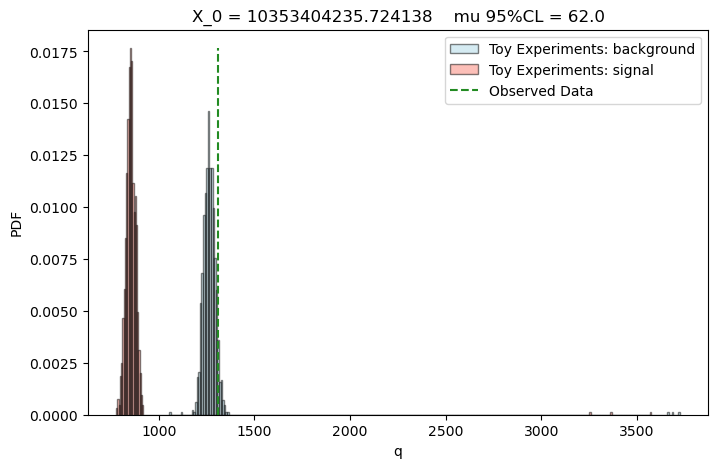

mu_CI: 62.0
---------------------
Testing x0: 10353415010.896551
Mu:  62.0    q(mu)_obs = 1409.513387381463
p_mu = 0.0   p_b = 0.0   ratio = nan 



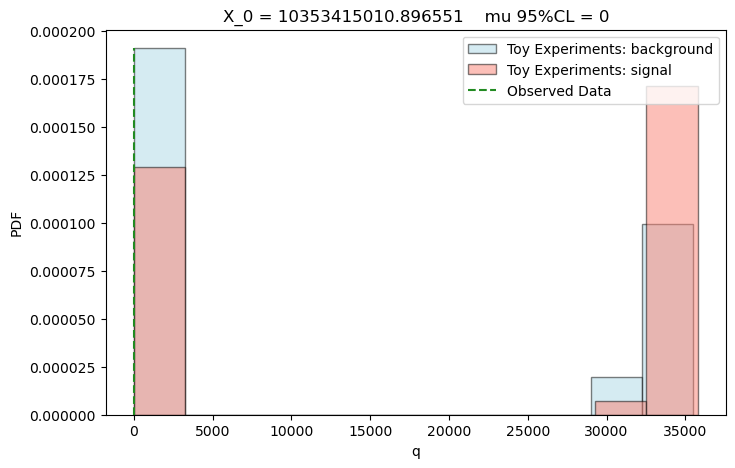

mu_CI: 0.0
---------------------
Testing x0: 10353425786.068966
Mu:  0.0    q(mu)_obs = -5.238689482212067e-10
p_mu = 0.626   p_b = 0.632   ratio = 0.990506329113924 

Mu:  10.0    q(mu)_obs = 51.33266644872492
p_mu = 0.005   p_b = 0.005   ratio = 1.0 

Mu:  20.0    q(mu)_obs = 163.36771780067284
p_mu = 0.001   p_b = 0.0   ratio = inf 

Mu:  30.0    q(mu)_obs = 336.0181002750942
p_mu = 0.0   p_b = 0.0   ratio = nan 



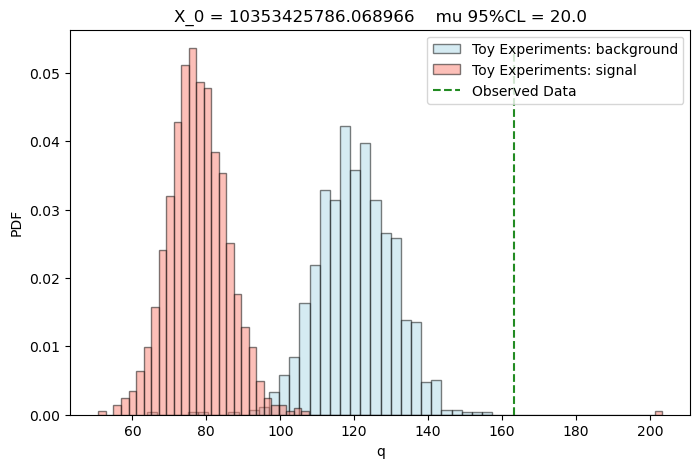

mu_CI: 20.0
---------------------
Testing x0: 10353436561.241379
Mu:  20.0    q(mu)_obs = 114.81828460799079
p_mu = 0.002   p_b = 0.222   ratio = 0.009009009009009009 

Mu:  18.0    q(mu)_obs = 93.48361009682776
p_mu = 0.002   p_b = 0.222   ratio = 0.009009009009009009 

Mu:  16.0    q(mu)_obs = 74.33677720629566
p_mu = 0.001   p_b = 0.222   ratio = 0.0045045045045045045 

Mu:  14.0    q(mu)_obs = 57.37841549555742
p_mu = 0.001   p_b = 0.222   ratio = 0.0045045045045045045 

Mu:  12.0    q(mu)_obs = 42.60915471644694
p_mu = 0.002   p_b = 0.222   ratio = 0.009009009009009009 

Mu:  10.0    q(mu)_obs = 30.029624813298142
p_mu = 0.011   p_b = 0.222   ratio = 0.04954954954954954 



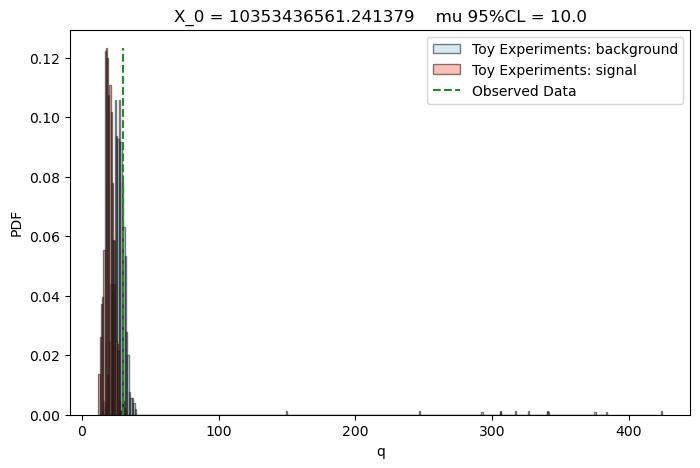

mu_CI: 10.0
---------------------
Testing x0: 10353447336.413794
Mu:  10.0    q(mu)_obs = 12.58048827332459
p_mu = 0.995   p_b = 1.0   ratio = 0.995 

Mu:  20.0    q(mu)_obs = 73.85742826399655
p_mu = 0.786   p_b = 0.998   ratio = 0.7875751503006012 

Mu:  30.0    q(mu)_obs = 186.0041039957032
p_mu = 0.215   p_b = 0.995   ratio = 0.21608040201005024 

Mu:  35.0    q(mu)_obs = 261.13046363949616
p_mu = 0.049   p_b = 0.995   ratio = 0.0492462311557789 



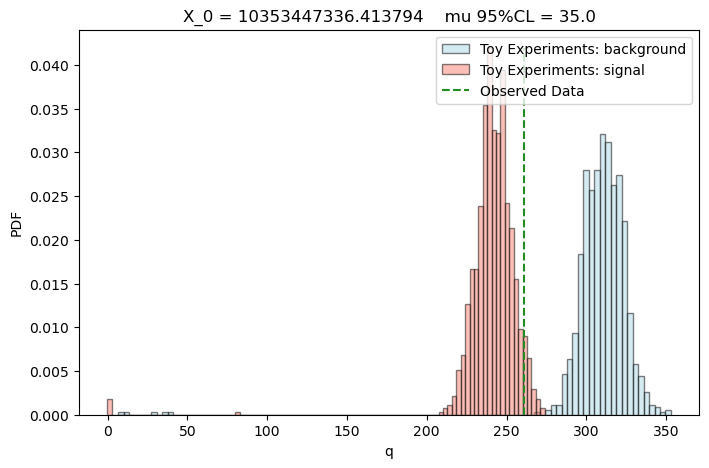

mu_CI: 35.0
---------------------


In [22]:
x0_3=all_freq[range(10,15)]
muCL3=stat.stat_test(runsData,x0_3,mu_fix=14,verbose=True,draw=True)

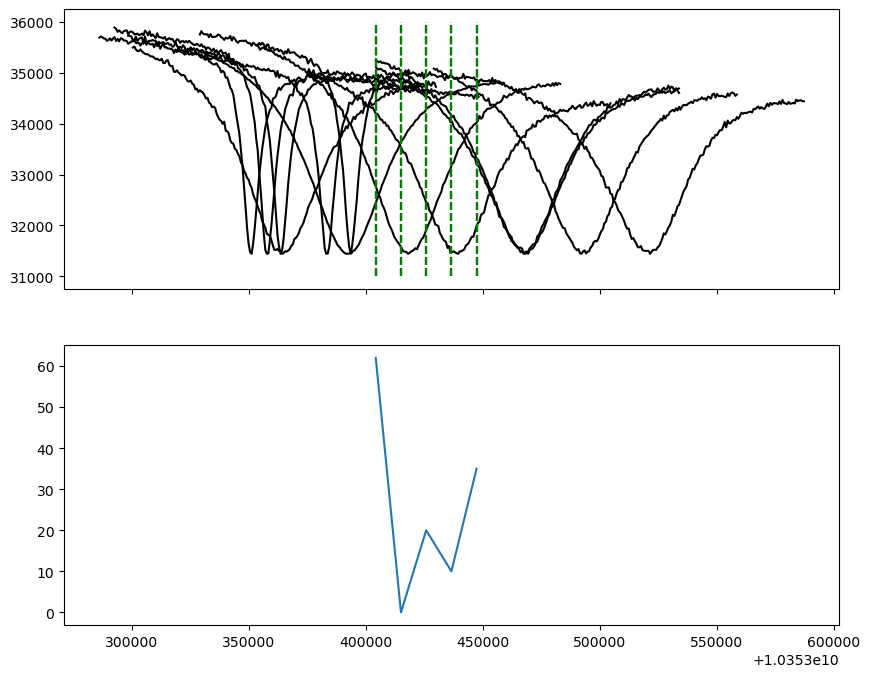

In [24]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0_3:
    ax[0].vlines(x0_3,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_3,muCL3)

#### Range(15,20)

Testing x0: 10353458111.586206
Mu:  35    q(mu)_obs = 234.89434417857046
p_mu = 0.035   p_b = 0.994   ratio = 0.035211267605633804 

Mu:  33.0    q(mu)_obs = 206.46950141384877
p_mu = 0.048   p_b = 0.994   ratio = 0.048289738430583505 



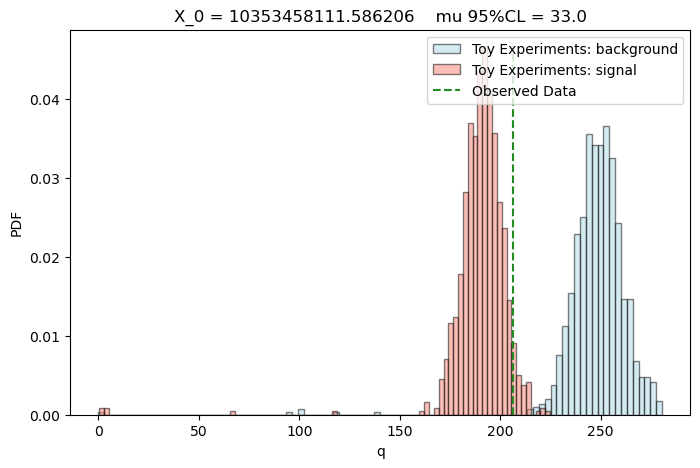

mu_CI: 33.0
---------------------
Testing x0: 10353468886.758621
Mu:  33.0    q(mu)_obs = 212.9052761540661
p_mu = 0.055   p_b = 0.986   ratio = 0.055780933062880324 



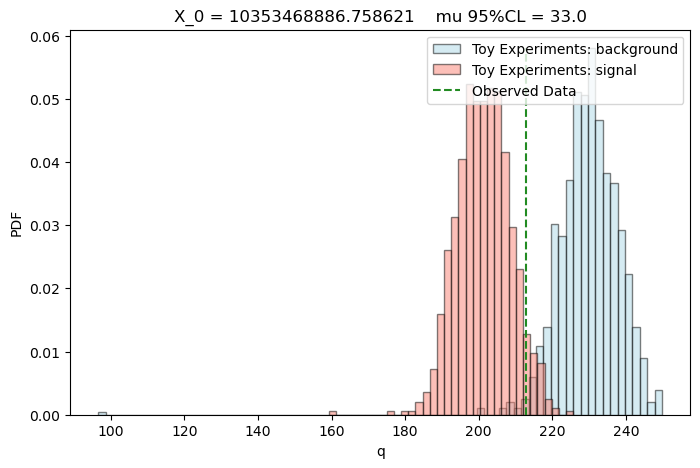

mu_CI: 33.0
---------------------
Testing x0: 10353479661.931034
Mu:  33.0    q(mu)_obs = 208.87063549099912
p_mu = 0.0   p_b = 0.797   ratio = 0.0 

Mu:  31.0    q(mu)_obs = 183.91089308456867
p_mu = 0.0   p_b = 0.797   ratio = 0.0 

Mu:  29.0    q(mu)_obs = 160.53661998268217
p_mu = 0.0   p_b = 0.797   ratio = 0.0 

Mu:  27.0    q(mu)_obs = 138.74828629524563
p_mu = 0.003   p_b = 0.797   ratio = 0.0037641154328732747 

Mu:  25.0    q(mu)_obs = 118.54636227969968
p_mu = 0.006   p_b = 0.798   ratio = 0.007518796992481203 

Mu:  23.0    q(mu)_obs = 99.93131834134692
p_mu = 0.008   p_b = 0.798   ratio = 0.010025062656641603 

Mu:  21.0    q(mu)_obs = 82.90362503318102
p_mu = 0.025   p_b = 0.798   ratio = 0.03132832080200501 

Mu:  19.0    q(mu)_obs = 67.46375305607216
p_mu = 0.047   p_b = 0.798   ratio = 0.05889724310776942 



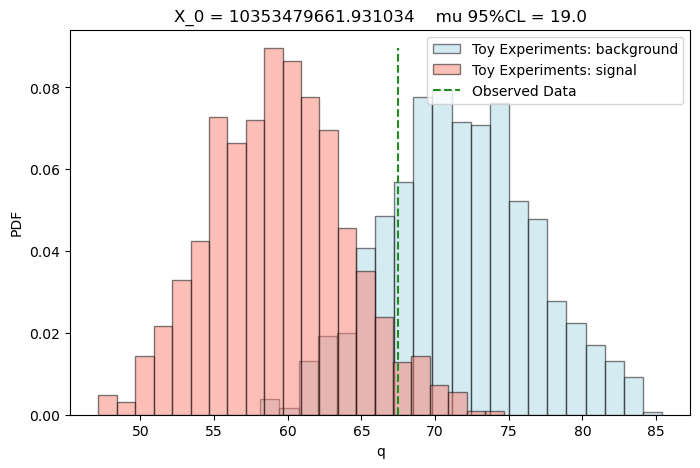

mu_CI: 19.0
---------------------
Testing x0: 10353490437.103449
Mu:  19.0    q(mu)_obs = 62.70379228605452
p_mu = 0.05   p_b = 0.661   ratio = 0.07564296520423601 

Mu:  21.0    q(mu)_obs = 76.8213575917107
p_mu = 0.025   p_b = 0.661   ratio = 0.037821482602118005 



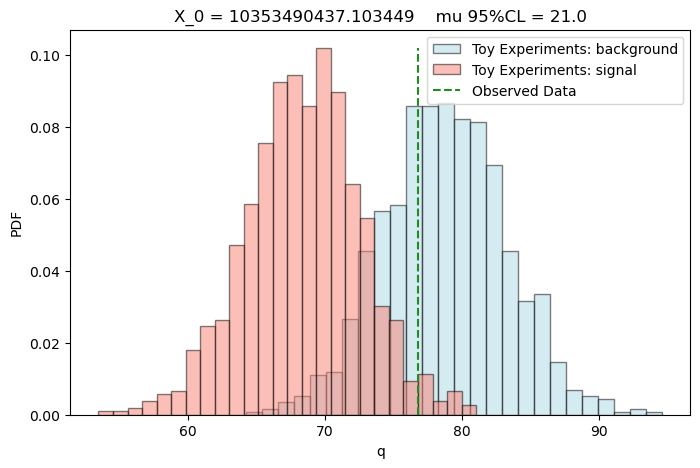

mu_CI: 21.0
---------------------
Testing x0: 10353501212.275862
Mu:  21.0    q(mu)_obs = 77.98342692059305
p_mu = 0.0   p_b = 0.064   ratio = 0.0 

Mu:  19.0    q(mu)_obs = 64.37668726941047
p_mu = 0.001   p_b = 0.064   ratio = 0.015625 

Mu:  17.0    q(mu)_obs = 52.069858399969235
p_mu = 0.002   p_b = 0.064   ratio = 0.03125 

Mu:  15.0    q(mu)_obs = 41.06332426494191
p_mu = 0.0   p_b = 0.064   ratio = 0.0 

Mu:  13.0    q(mu)_obs = 31.35746893700707
p_mu = 0.001   p_b = 0.064   ratio = 0.015625 

Mu:  11.0    q(mu)_obs = 22.952676609285845
p_mu = 0.004   p_b = 0.064   ratio = 0.0625 



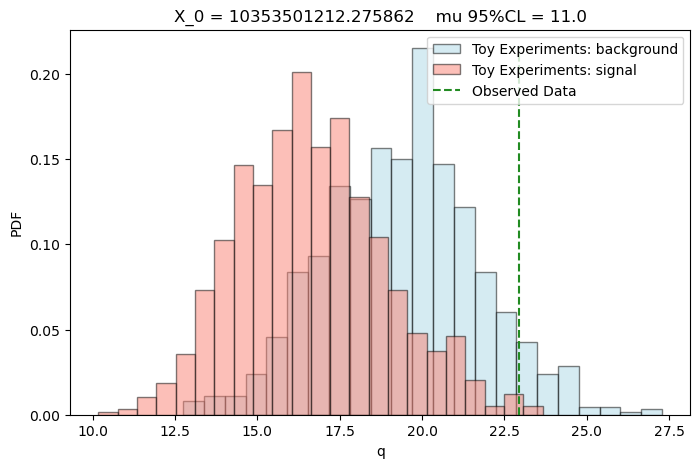

mu_CI: 11.0
---------------------


In [34]:
x0_4=all_freq[range(15,20)]
muCL4=stat.stat_test(runsData,x0_4,mu_fix=35,verbose=True,draw=True)

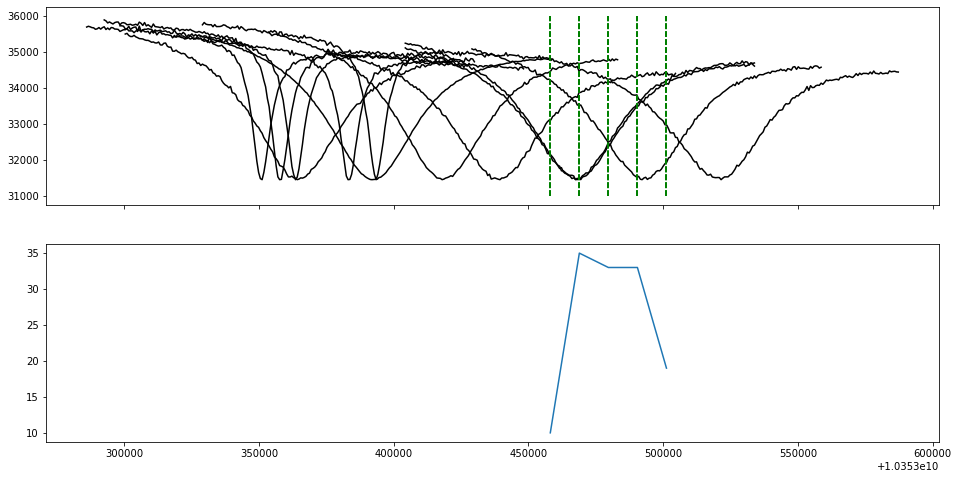

In [39]:
fig,ax=plt.subplots(2,1,figsize=(16,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0_4:
    ax[0].vlines(x0_4,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_4,muCL4)
plt.show()

#### Range(20,25)

Testing x0: 10353511987.448277
Mu:  11    q(mu)_obs = 22.402345293216058
p_mu = 0.001   p_b = 0.037   ratio = 0.02702702702702703 

Mu:  9.0    q(mu)_obs = 15.741413581414236
p_mu = 0.002   p_b = 0.037   ratio = 0.05405405405405406 



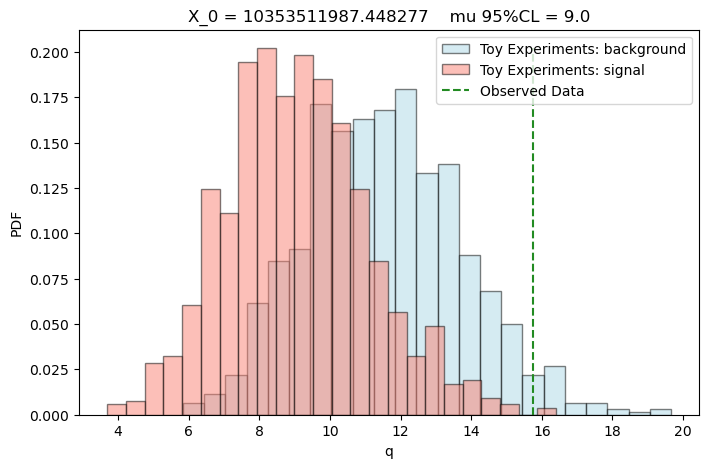

mu_CI: 9.0
---------------------
Testing x0: 10353522762.62069
Mu:  9.0    q(mu)_obs = 10.964394484239165
p_mu = 0.17   p_b = 0.437   ratio = 0.3890160183066362 

Mu:  16.0    q(mu)_obs = 34.3990240059029
p_mu = 0.045   p_b = 0.437   ratio = 0.10297482837528604 

Mu:  18.0    q(mu)_obs = 43.48823328470098
p_mu = 0.034   p_b = 0.437   ratio = 0.07780320366132723 

Mu:  20.0    q(mu)_obs = 53.6406872072439
p_mu = 0.03   p_b = 0.437   ratio = 0.06864988558352403 

Mu:  22.0    q(mu)_obs = 64.85607068594618
p_mu = 0.014   p_b = 0.437   ratio = 0.032036613272311214 



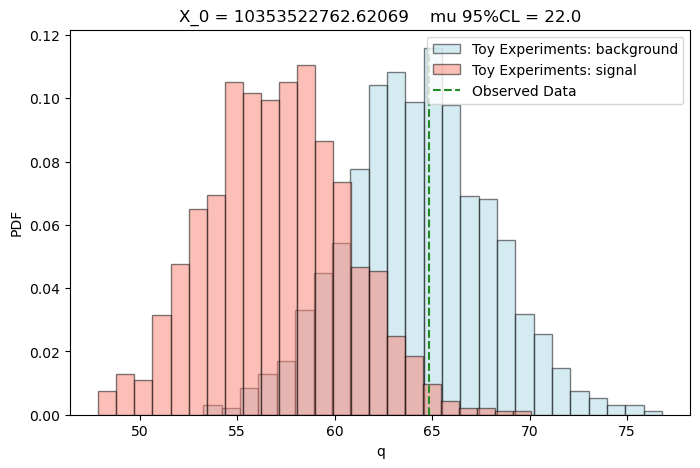

mu_CI: 22.0
---------------------
Testing x0: 10353533537.793104
Mu:  22.0    q(mu)_obs = 45.0904611245096
p_mu = 0.112   p_b = 0.875   ratio = 0.128 

Mu:  24.0    q(mu)_obs = 54.17375600869491
p_mu = 0.073   p_b = 0.875   ratio = 0.08342857142857142 

Mu:  26.0    q(mu)_obs = 64.08895329129155
p_mu = 0.044   p_b = 0.875   ratio = 0.05028571428571428 



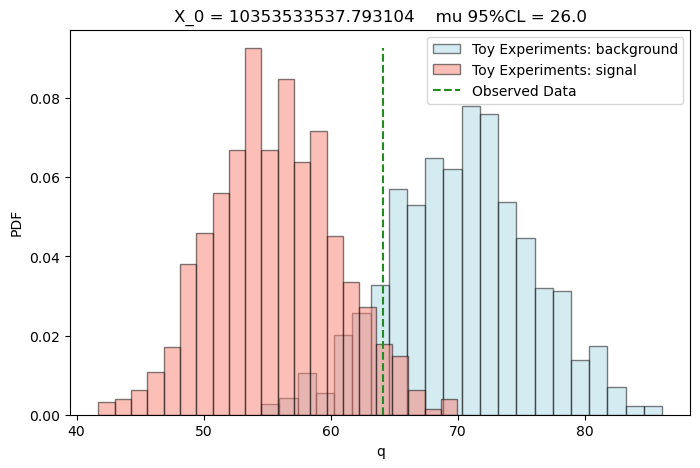

mu_CI: 26.0
---------------------
Testing x0: 10353544312.965517
Mu:  26.0    q(mu)_obs = 42.08031946048504
p_mu = 0.264   p_b = 0.944   ratio = 0.2796610169491526 

Mu:  33.0    q(mu)_obs = 69.96745968734831
p_mu = 0.1   p_b = 0.944   ratio = 0.10593220338983052 

Mu:  35.0    q(mu)_obs = 79.22840890939551
p_mu = 0.087   p_b = 0.944   ratio = 0.09216101694915255 

Mu:  37.0    q(mu)_obs = 89.06381577072898
p_mu = 0.064   p_b = 0.944   ratio = 0.06779661016949153 

Mu:  39.0    q(mu)_obs = 99.47351909376084
p_mu = 0.039   p_b = 0.944   ratio = 0.0413135593220339 



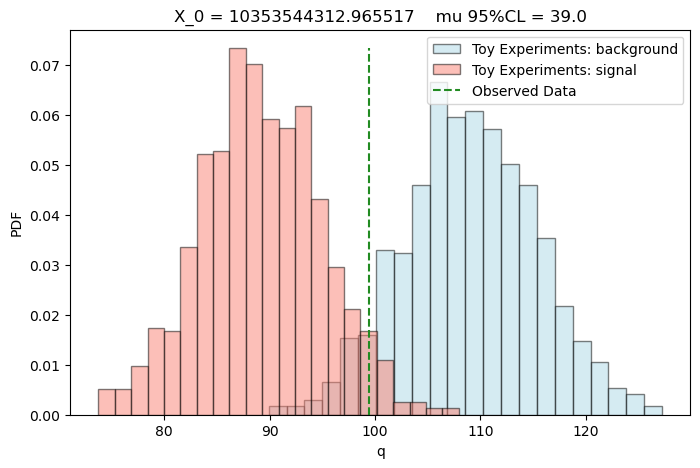

mu_CI: 39.0
---------------------
Testing x0: 10353555088.137932
Mu:  39.0    q(mu)_obs = 86.2580726840315
p_mu = 0.0   p_b = 0.409   ratio = 0.0 

Mu:  37.0    q(mu)_obs = 77.67348902823869
p_mu = 0.001   p_b = 0.409   ratio = 0.0024449877750611247 

Mu:  35.0    q(mu)_obs = 69.5379874507853
p_mu = 0.003   p_b = 0.409   ratio = 0.007334963325183375 

Mu:  33.0    q(mu)_obs = 61.85169906233932
p_mu = 0.002   p_b = 0.409   ratio = 0.004889975550122249 

Mu:  31.0    q(mu)_obs = 54.61475501398672
p_mu = 0.003   p_b = 0.409   ratio = 0.007334963325183375 

Mu:  29.0    q(mu)_obs = 47.82728649726778
p_mu = 0.006   p_b = 0.409   ratio = 0.01466992665036675 

Mu:  27.0    q(mu)_obs = 41.489424744249845
p_mu = 0.009   p_b = 0.409   ratio = 0.022004889975550123 

Mu:  25.0    q(mu)_obs = 35.60130102737094
p_mu = 0.019   p_b = 0.409   ratio = 0.04645476772616137 



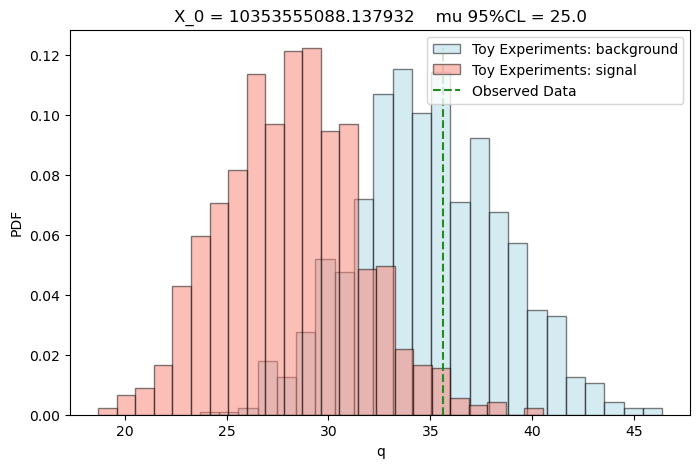

mu_CI: 25.0
---------------------


In [37]:
x0_5=all_freq[range(20,25)]
muCL5=stat.stat_test(runsData,x0_5,mu_fix=11,verbose=True,draw=True)

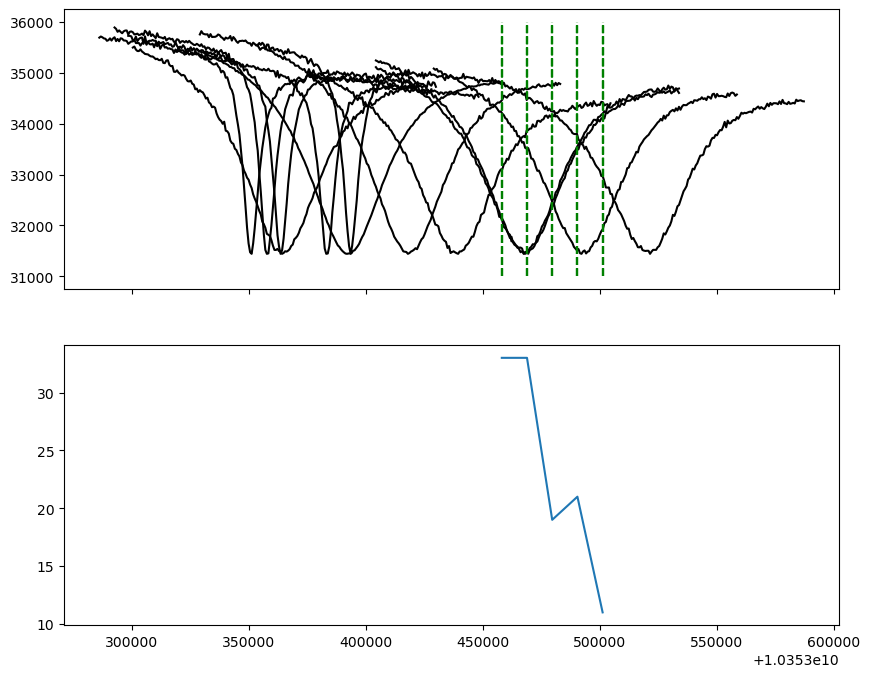

In [35]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0_5:
    ax[0].vlines(x0_5,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_5,muCL5)

#### Range(25,30)

Testing x0: 10353565863.310345
Mu:  25    q(mu)_obs = 29.310980478410784
p_mu = 0.0   p_b = 0.126   ratio = 0.0 

Mu:  23.0    q(mu)_obs = 25.196393431830074
p_mu = 0.0   p_b = 0.126   ratio = 0.0 

Mu:  21.0    q(mu)_obs = 21.389286552639533
p_mu = 0.002   p_b = 0.126   ratio = 0.015873015873015872 

Mu:  19.0    q(mu)_obs = 17.889744136977242
p_mu = 0.001   p_b = 0.126   ratio = 0.007936507936507936 

Mu:  17.0    q(mu)_obs = 14.69785050574501
p_mu = 0.002   p_b = 0.126   ratio = 0.015873015873015872 

Mu:  15.0    q(mu)_obs = 11.813690004677483
p_mu = 0.005   p_b = 0.126   ratio = 0.03968253968253968 

Mu:  13.0    q(mu)_obs = 9.237347004389449
p_mu = 0.006   p_b = 0.126   ratio = 0.047619047619047616 



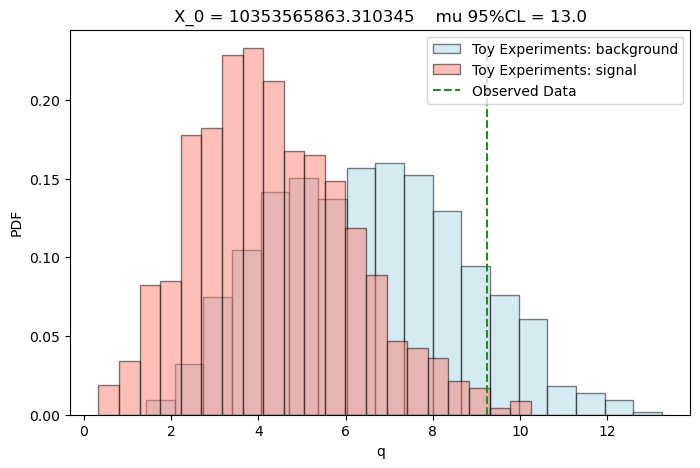

mu_CI: 13.0
---------------------
Testing x0: 10353576638.48276
Mu:  13.0    q(mu)_obs = 5.806511744809541
p_mu = 0.121   p_b = 0.33   ratio = 0.36666666666666664 

Mu:  20.0    q(mu)_obs = 13.234611376101384
p_mu = 0.047   p_b = 0.33   ratio = 0.14242424242424243 

Mu:  25.0    q(mu)_obs = 20.381652042866335
p_mu = 0.047   p_b = 0.33   ratio = 0.14242424242424243 

Mu:  30.0    q(mu)_obs = 29.0617975828427
p_mu = 0.025   p_b = 0.33   ratio = 0.07575757575757576 

Mu:  32.0    q(mu)_obs = 32.962873450782354
p_mu = 0.02   p_b = 0.33   ratio = 0.06060606060606061 

Mu:  34.0    q(mu)_obs = 37.108994443933625
p_mu = 0.014   p_b = 0.33   ratio = 0.04242424242424242 



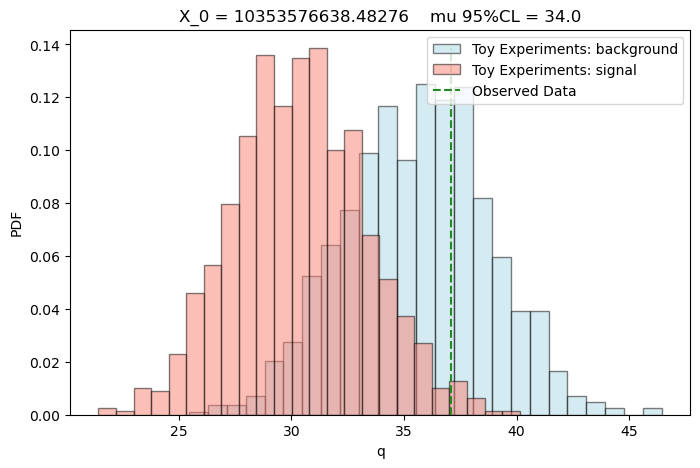

mu_CI: 34.0
---------------------
Testing x0: 10353587413.655172
Mu:  34.0    q(mu)_obs = 16.98810169364515
p_mu = 0.171   p_b = 0.74   ratio = 0.2310810810810811 

Mu:  39.0    q(mu)_obs = 22.70606837381638
p_mu = 0.108   p_b = 0.74   ratio = 0.14594594594594595 

Mu:  44.0    q(mu)_obs = 29.250374963441573
p_mu = 0.077   p_b = 0.74   ratio = 0.10405405405405406 

Mu:  46.0    q(mu)_obs = 32.09934072265605
p_mu = 0.061   p_b = 0.74   ratio = 0.08243243243243244 

Mu:  48.0    q(mu)_obs = 35.08038884594498
p_mu = 0.055   p_b = 0.74   ratio = 0.07432432432432433 

Mu:  50.0    q(mu)_obs = 38.19348164009352
p_mu = 0.038   p_b = 0.74   ratio = 0.05135135135135135 



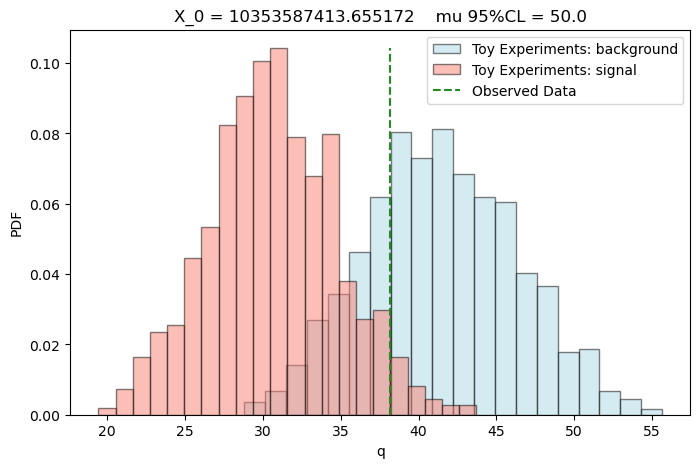

mu_CI: 50.0
---------------------
Testing x0: 10353598188.827587
Mu:  50.0    q(mu)_obs = 4.130798985079309
p_mu = 0.253   p_b = 0.748   ratio = 0.3382352941176471 

Mu:  57.0    q(mu)_obs = 5.652233779634116
p_mu = 0.208   p_b = 0.748   ratio = 0.27807486631016043 

Mu:  64.0    q(mu)_obs = 7.411404293263331
p_mu = 0.138   p_b = 0.748   ratio = 0.18449197860962568 

Mu:  69.0    q(mu)_obs = 8.813439305209613
p_mu = 0.115   p_b = 0.748   ratio = 0.1537433155080214 

Mu:  74.0    q(mu)_obs = 10.33666096633533
p_mu = 0.087   p_b = 0.748   ratio = 0.11631016042780748 

Mu:  76.0    q(mu)_obs = 10.979871904342872
p_mu = 0.076   p_b = 0.748   ratio = 0.10160427807486631 

Mu:  78.0    q(mu)_obs = 11.642462719177274
p_mu = 0.06   p_b = 0.748   ratio = 0.08021390374331551 

Mu:  80.0    q(mu)_obs = 12.324430558554013
p_mu = 0.052   p_b = 0.748   ratio = 0.06951871657754011 

Mu:  82.0    q(mu)_obs = 13.025772570552363
p_mu = 0.067   p_b = 0.748   ratio = 0.089572192513369 

Mu:  84.0    q(mu)

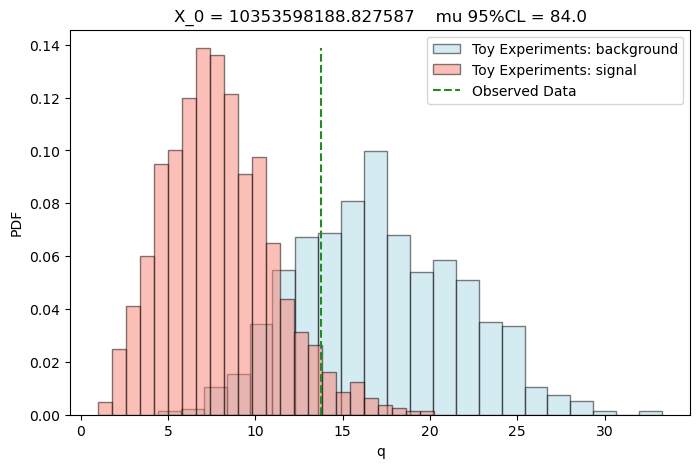

mu_CI: 84.0
---------------------
Testing x0: 10353608964.0
Mu:  84.0    q(mu)_obs = 0.008838762794766808
p_mu = 0.914   p_b = 0.937   ratio = 0.9754535752401281 

Mu:  94.0    q(mu)_obs = 0.02933869585103821
p_mu = 0.82   p_b = 0.882   ratio = 0.929705215419501 

Mu:  104.0    q(mu)_obs = 0.06177655102146673
p_mu = 0.761   p_b = 0.844   ratio = 0.9016587677725119 

Mu:  114.0    q(mu)_obs = 0.10615060735290172
p_mu = 0.692   p_b = 0.82   ratio = 0.8439024390243902 

Mu:  124.0    q(mu)_obs = 0.1624591441686789
p_mu = 0.637   p_b = 0.803   ratio = 0.7932752179327521 

Mu:  134.0    q(mu)_obs = 0.23070044107589638
p_mu = 0.589   p_b = 0.79   ratio = 0.7455696202531645 

Mu:  144.0    q(mu)_obs = 0.31087277795450063
p_mu = 0.547   p_b = 0.779   ratio = 0.7021822849807445 

Mu:  154.0    q(mu)_obs = 0.4029744349682005
p_mu = 0.567   p_b = 0.777   ratio = 0.7297297297297296 

Mu:  164.0    q(mu)_obs = 0.5070036925098975
p_mu = 0.474   p_b = 0.775   ratio = 0.6116129032258064 

Mu:  174.0  

KeyboardInterrupt: 

In [39]:
x0_6=all_freq[range(25,30)]
muCL6=stat.stat_test(runsData,x0_6,mu_fix=25,verbose=True,draw=True)

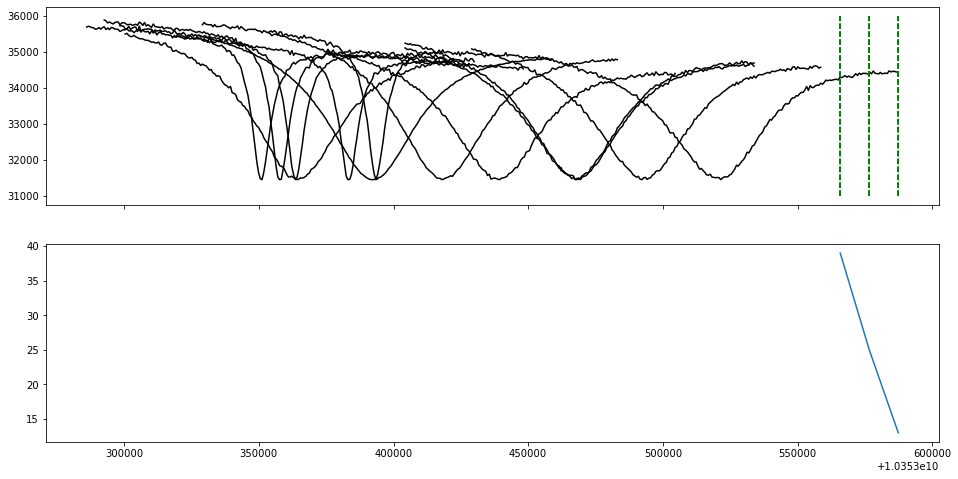

In [37]:
fig,ax=plt.subplots(2,1,figsize=(16,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0_6:
    ax[0].vlines(x0_6,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_6,muCL6)
plt.show()

#### Complete test

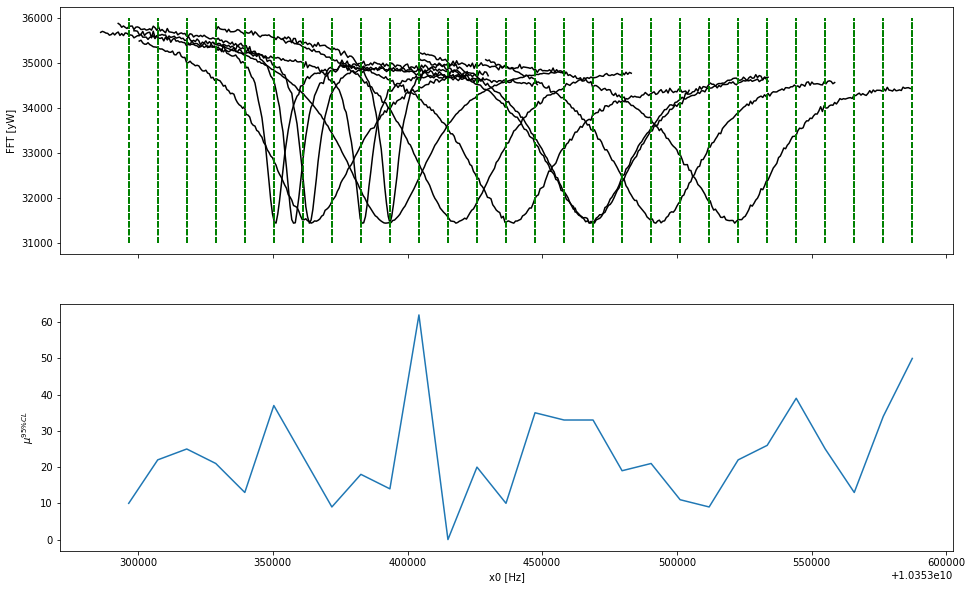

In [33]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

x0 = all_freq[range(0,28)]
muCL = np.array([10,22,25,21,13,37,23,9,18,14,62,0,20,10,35,33,33,19,21,11,9,22,26,39,25,13,34,50])

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")
    ax[0].vlines(x0,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0,muCL)

ax[0].set_ylabel("FFT [yW]")
ax[1].set_xlabel("x0 [Hz]")
ax[1].set_ylabel(r'$\mu^{95\%CL}$')
plt.show()

### 3.3 Parallelization of Confidence interval test <a name="parallel"></a>

In [40]:
result_final=np.array([[1.03532965e+10, 8.00000000e+00, 8.62944162e-02],
       [1.03533073e+10, 2.20000000e+01, 5.03951555e-02],
       [1.03533180e+10, 2.50000000e+01, 5.91597313e-02],
       [1.03533288e+10, 2.20000000e+01, 3.99559383e-02],
       [1.03533396e+10, 1.30000000e+01, 5.67639874e-02],
       [1.03533504e+10, 3.30000000e+01, 7.34042553e-01],
       [1.03533611e+10, 2.50000000e+01, 2.50000000e-01],
       [1.03533719e+10, 8.00000000e+00, 4.20253165e-02],
       [1.03533827e+10, 1.80000000e+01, 7.35414117e-02],
       [1.03533935e+10, 1.50000000e+01, 7.85969471e-02],
       [1.03534042e+10, 5.80000000e+01, 5.96330275e-02],
       [1.03534150e+10, 2.00000000e+01, 1.40000000e-01],
       [1.03534258e+10, 2.50000000e+01, 1.05000000e+01],
       [1.03534366e+10, 8.00000000e+00, 5.70440795e-02],
       [1.03534473e+10, 3.40000000e+01, 6.07551717e-02],
       [1.03534581e+10, 3.30000000e+01, 3.02239181e-02],
       [1.03534689e+10, 3.30000000e+01, 5.83882413e-02],
       [1.03534797e+10, 1.90000000e+01, 5.34889687e-02],
       [1.03534904e+10, 2.10000000e+01, 4.16731944e-02],
       [1.03535012e+10, 1.10000000e+01, 4.25531915e-02],
       [1.03535120e+10, 9.00000000e+00, 4.67289720e-02],
       [1.03535228e+10, 2.20000000e+01, 4.01937046e-02],
       [1.03535335e+10, 2.60000000e+01, 5.20471895e-02],
       [1.03535443e+10, 3.90000000e+01, 4.34968473e-02],
       [1.03535551e+10, 2.50000000e+01, 4.32832474e-02],
       [1.03535659e+10, 1.50000000e+01, 4.01785714e-02],
       [1.03535766e+10, 3.40000000e+01, 4.55927052e-02],
       [1.03535874e+10, 5.00000000e+01, 5.22736365e-02]])

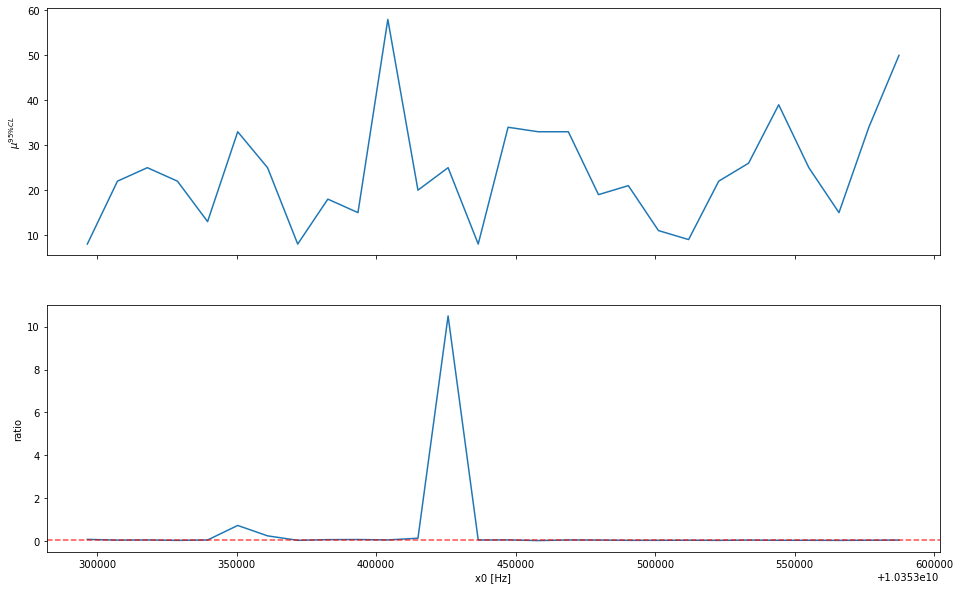

In [50]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

ax[0].plot(result_final[:28,0], result_final[:28,1])
ax[0].set_ylabel(r'$\mu^{95\%CL}$')

ax[1].plot(result_final[:28,0], result_final[:28,2])
ax[1].axhline(0.05, color='red',linestyle="dashed",alpha=0.7)
ax[1].set_ylabel('ratio')
ax[1].set_xlabel('x0 [Hz]')

plt.show()